# This is the minimum Working Example to compute a multiple scattering experiment in the Q-Phase 

In [9]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
Created on Sat Jun 10 19:53:32 2017

@author: Bene

This file creates a fwd-model for the TESCAN Q-PHASE under 
multiple-scattering. It is majorly derived from  "LEarning approach for optical tomography"
U. S. Kamilov, BIG, EPFL, 2014.
"""
# %load_ext autoreload
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
from datetime import datetime

# load own functions
import src.model as mus
import src.tf_helper as tf_helper
import src.tf_generate_object as tf_go
import src.data as data
import src.optimization.tf_regularizers as reg


# change the following to %matplotlib notebook for interactive plotting
# %matplotlib inline

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 6))
mpl.rc('image', cmap='gray')


# Define some optimization parameters 

In [10]:
'''Define some stuff related to infrastructure'''
mytimestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
savepath = os.path.join('./Data/DROPLETS/RESULTS/')#, mytimestamp)

# Create directory
try: 
    os.mkdir(savepath)
except(FileExistsError): 
    print('Folder exists already')

# Define parameters 
is_padding = True
is_display = True
is_optimization = True 
is_optimization_psf = False
is_flip = False

# data files for parameters and measuremets 
matlab_val_file = './Data/DROPLETS/allAmp_simu.npy' #'./Data/DROPLETS/allAmp_simu.mat'      
matlab_par_file = './Data/DROPLETS/myParameterNew.mat'   

# microscope parameters
zernikefactors = np.array((0,0,0,0,0,0,.5,.5,0)) # representing the 9 first zernike coefficients in noll-writings 
dn = .075 # refractive index of the object (difference)

'''Define Optimization Parameters'''
my_learningrate = 1e-2  # learning rate
lambda_tv = 1e-4 # lambda for Total variation
lambda_gr = 0 # lambda for Goods Roughness 
lambda_pos = 10
lambda_neg = 10

Niter = 1000
Ndisplay = 10


'''START CODE'''
tf.reset_default_graph() # just in case there was an open session

# Generate Test-Object

In [11]:
''' File which stores the experimental parameters from the Q-PHASE setup 
    1.) Read in the parameters of the dataset ''' 
matlab_pars = data.import_parameters_mat(filename = matlab_par_file, matname='myParameterNew')

''' 2.) Read in the parameters of the dataset ''' 
if(matlab_val_file.find('mat')==-1):
    matlab_val = np.load(matlab_val_file)
else:
    matlab_val = data.import_realdata_h5(filename = matlab_val_file, matname='allAmp_red', is_complex=True)

if(is_flip):
    np_meas = np.flip(matlab_val,0)
    print('Attention: We are flipping the data!')
else:
    np_meas = matlab_val
print('do we need to flip the data?! -> Observe FFT!!')


''' Create the Model'''
muscat = mus.MuScatModel(matlab_pars, is_optimization=is_optimization, is_optimization_psf = is_optimization_psf)
muscat.Nx,muscat.Ny = int(np.squeeze(matlab_pars['Nx'].value)), int(np.squeeze(matlab_pars['Ny'].value))
muscat.shiftIcY=0
muscat.shiftIcX=0
muscat.dn = dn
muscat.NAc =.4
muscat.dz = muscat.lambda0/4
print('Attention: Changed Z-sampling!!')

''' Adjust some parameters to fit it in the memory '''
muscat.mysize = (muscat.Nz,muscat.Nx,muscat.Ny) # ordering is (Nillu, Nz, Nx, Ny)

''' Create a 3D Refractive Index Distributaton as a artificial sample'''
obj = tf_go.generateObject(mysize=muscat.mysize, obj_dim=muscat.dx, obj_type ='sphere', diameter = 1, dn = muscat.dn)

# introduce zernike factors here
muscat.zernikefactors = zernikefactors

do we need to flip the data?! -> Observe FFT!!
Assigned some value for dn which is not good!


# Compute the System's properties (e.g. Pupil function/Illumination Source, K-vectors, etc.)

In [13]:
''' Compute the systems model'''
muscat.computesys(obj, is_zernike=True)

----------> Be aware: We are taking aberrations into account!
Shifting the illumination in X by: 0 Pixel
Shifting the illumination in Y by: 0 Pixel
Number of Illumination Angles / Plane waves: 49


# Generate Computational Graph (fwd model)

In [14]:
tf_fwd = muscat.computemodel()

if(is_display): 
    plt.subplot(131), plt.title('Ic'), plt.imshow(muscat.Ic)
    plt.subplot(132), plt.title('Po'),plt.imshow(np.fft.fftshift(np.abs(muscat.Po))), plt.colorbar()
    plt.subplot(133), plt.title('Po'),plt.imshow(np.fft.fftshift(np.angle(muscat.Po))), plt.colorbar(), plt.show()

Buildup Q-PHASE Model 


# Compute the fwd model with a guess-object and compare to real measurement

In [15]:
''' Evaluate the model '''
sess = tf.Session()
sess.run(tf.initialize_all_variables())
myres = sess.run(tf_fwd, feed_dict={muscat.TF_obj:obj})

## Compare Phase of measured and simulated data

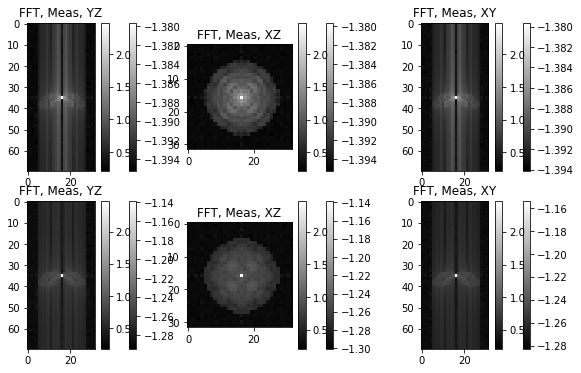

In [16]:
# add noise
myres_noise = myres + 0.000*np.random.randn(muscat.Nz,muscat.Nx,muscat.Ny)

plt.subplot(231)
plt.title('YZ'),plt.imshow(np.angle(myres_noise)[:,muscat.mysize[1]//2,:]), plt.colorbar()
plt.subplot(232)
plt.title('XZ'),plt.imshow(np.angle(myres_noise)[:,:,muscat.mysize[2]//2]), plt.colorbar()
plt.subplot(233)
plt.title('XY'),plt.imshow(np.angle(myres_noise)[muscat.mysize[0]//2,:,:]), plt.colorbar()

plt.subplot(234)
plt.title('Experiment: YZ'),plt.imshow(np.angle(matlab_val)[:,muscat.mysize[1]//2,:]), plt.colorbar()
plt.subplot(235)
plt.title('Experiment: XZ'),plt.imshow(np.angle(matlab_val)[:,:,muscat.mysize[2]//2]), plt.colorbar()
plt.subplot(236)
plt.title('Experiment: XY'),plt.imshow(np.angle(matlab_val)[muscat.mysize[0]//2,:,:]), plt.colorbar()
#data.save_timeseries(np.angle(matlab_val), 'droplet_meas_angle')
#data.save_timeseries(np.angle(myres), 'droplet_simu_angle')   

is_display = True
if(is_display): plt.subplot(231),plt.title('FFT, Meas, YZ'), plt.imshow(np.abs(np.fft.fftshift(np.fft.fftn(matlab_val))**.1)[:,muscat.mysize[1]//2,:]), plt.colorbar()#, plt.show()    
if(is_display): plt.subplot(232),plt.title('FFT, Meas, XZ'), plt.imshow(np.abs(np.fft.fftshift(np.fft.fftn(matlab_val))**.1)[muscat.mysize[0]//2,:,:]), plt.colorbar()#, plt.show()   
if(is_display): plt.subplot(233),plt.title('FFT, Meas, XY'), plt.imshow(np.abs(np.fft.fftshift(np.fft.fftn(matlab_val))**.1)[:,:,muscat.mysize[2]//2]), plt.colorbar()#, plt.show()     
if(is_display): plt.subplot(234),plt.title('FFT, Meas, YZ'), plt.imshow(np.abs(np.fft.fftshift(np.fft.fftn(myres_noise))**.1)[:,muscat.mysize[1]//2,:]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(235),plt.title('FFT, Meas, XZ'), plt.imshow(np.abs(np.fft.fftshift(np.fft.fftn(myres_noise))**.1)[muscat.mysize[0]//2,:,:]), plt.colorbar()#, plt.show()    
if(is_display): plt.subplot(236),plt.title('FFT, Meas, XY'), plt.imshow(np.abs(np.fft.fftshift(np.fft.fftn(myres_noise))**.1)[:,:,muscat.mysize[2]//2]), plt.colorbar(), plt.show()    


# Define Optimizer and Cost-function

Now load data which has been saved previously (Optional!)

In [17]:
#%%
'''Regression + Regularization'''
tf_meas = tf.placeholder(dtype=tf.complex64, shape=muscat.mysize)
             
'''Define Cost-function'''
tf_tvloss = lambda_tv*reg.tf_total_variation_regularization(muscat.TF_obj)  #Alernatively total_variation
tf_posloss = lambda_neg*reg.posiminity(muscat.TF_obj, minval=-.2)
tf_negloss = lambda_pos*reg.posimaxity(muscat.TF_obj, maxval=.2)  
tf_fidelity = tf.reduce_sum(tf_helper.tf_abssqr(tf_meas - tf_fwd))

tf_loss = tf_fidelity +  tf_negloss + tf_posloss + tf_tvloss

 # data fidelity
# TV regularization
# Positivity Penalty          
# eventually Goods Roughness reg
          
          
'''Define Optimizer'''
tf_optimizer = tf.train.AdamOptimizer(my_learningrate)
tf_lossop = tf_optimizer.minimize(tf_loss)


# this is the initial guess of the reconstruction
if(False):
    init_guess = np.angle(np_meas) - np.min(np.angle(np_meas))
    init_guess = init_guess/np.max(init_guess)*muscat.dn
else:
    init_guess = np.ones(np_meas.shape)*muscat.dn

    ''' Evaluate the model '''
sess = tf.Session()
sess.run(tf.global_variables_initializer())
sess.run(tf.assign(muscat.TF_obj, init_guess)); # assign abs of measurement as initial guess of 


Regularizer: Penalize Values less then -0.2
Regularizer: Penalize Values higher then 0.2


# Optimize

Start optimizing
MY loss: @10: 414.0353 - Fidelity: 414.03418, Neg: 0.0, Pos: 0.0, TV: 0.0011269683
MY loss: @20: 26.738745 - Fidelity: 26.737617, Neg: 0.0, Pos: 0.0, TV: 0.0011272246
MY loss: @30: 82.51486 - Fidelity: 82.51373, Neg: 0.0, Pos: 0.0, TV: 0.0011273037
MY loss: @40: 10.632164 - Fidelity: 10.631037, Neg: 0.0, Pos: 0.0, TV: 0.00112724
MY loss: @50: 13.9821415 - Fidelity: 13.981014, Neg: 0.0, Pos: 0.0, TV: 0.0011271844
MY loss: @60: 8.428997 - Fidelity: 8.42787, Neg: 0.0, Pos: 0.0, TV: 0.0011272015
MY loss: @70: 7.1200485 - Fidelity: 7.118917, Neg: 0.0, Pos: 4.276122e-06, TV: 0.0011272411
MY loss: @80: 6.582098 - Fidelity: 6.5809107, Neg: 0.0, Pos: 5.986558e-05, TV: 0.0011272434
MY loss: @90: 6.1885586 - Fidelity: 6.1872272, Neg: 0.0, Pos: 0.00020389775, TV: 0.0011272345
MY loss: @100: 5.9615574 - Fidelity: 5.959981, Neg: 0.0, Pos: 0.0004492751, TV: 0.0011272395
MY loss: @110: 5.766242 - Fidelity: 5.764248, Neg: 0.0, Pos: 0.0008667324, TV: 0.0011272493
MY loss: @120: 5.597317

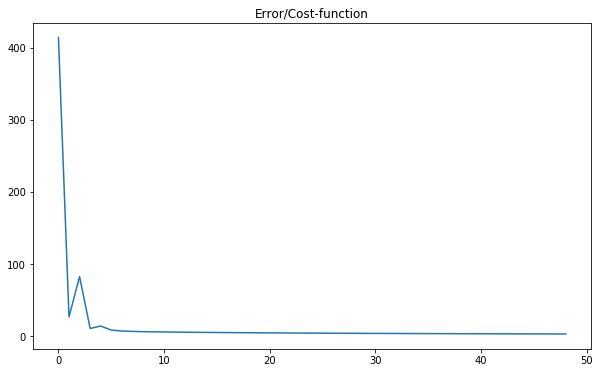

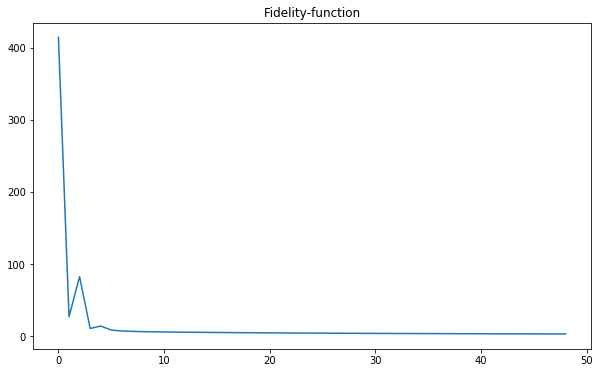

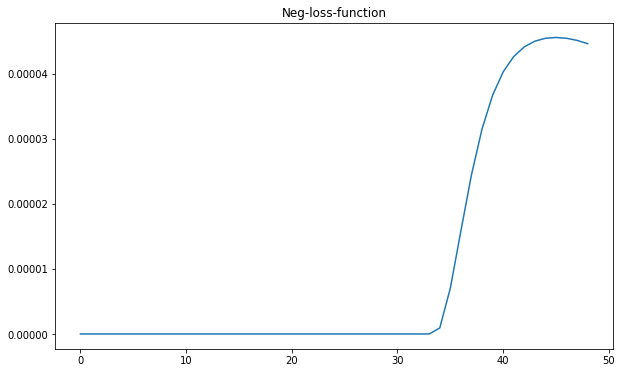

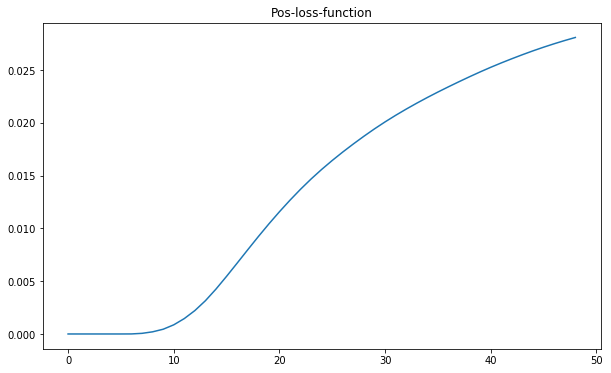

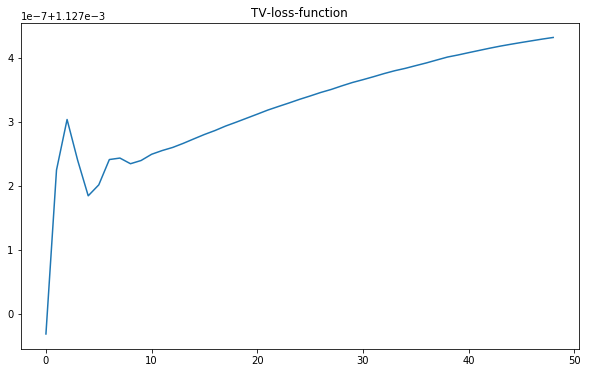

(<matplotlib.text.Text at 0x7f2d373d5358>,
 None)

In [18]:
#%%
''' Optimize the model '''
print('Start optimizing')
mylosslist = []
myfidelitylist = []
myposlosslist = []
myneglosslist = []
mytvlosslist = []
resultlist = []
for iterx in range(1,Niter):
    # try to optimize
    
    if(not np.mod(iterx, Ndisplay)):
        my_opt, my_res, my_loss, my_fidelity, my_negloss, my_posloss, my_tvloss =  \
            sess.run([tf_lossop, muscat.TF_obj, tf_loss, tf_fidelity, tf_negloss, tf_posloss, tf_tvloss], feed_dict={tf_meas:np_meas})
        
        print('MY loss: @'+str(iterx)+': ' + str(my_loss) + ' - Fidelity: '+str(my_fidelity)+', Neg: '+str(my_negloss)+', Pos: '+str(my_posloss)+', TV: '+str(my_tvloss))        
        mylosslist.append(my_loss)
        myfidelitylist.append(my_fidelity)
        myposlosslist.append(my_negloss)
        myneglosslist.append(my_posloss)
        mytvlosslist.append(my_tvloss)
        resultlist.append(my_res)
    else:
        sess.run([tf_lossop], feed_dict={tf_meas:np_meas})
        #plt.imshow(np.abs(my_res[:,50,:]))
        
# diplay the error over time
plt.title('Error/Cost-function'), plt.plot(np.array(mylosslist)), plt.show()
plt.title('Fidelity-function'), plt.plot(np.array(myfidelitylist)), plt.show()
plt.title('Neg-loss-function'), plt.plot(np.array(myposlosslist)), plt.show()
plt.title('Pos-loss-function'), plt.plot(np.array(myneglosslist)), plt.show()
plt.title('TV-loss-function'), plt.plot(np.array(mytvlosslist)), plt.show()

#save stack to disk
#sktiff.imsave(savepath+'Obj_Reconstruction.tif', np.array(resultlist), compress=6, metadata={'axes': 'TZXY'})

# Display result - FFT

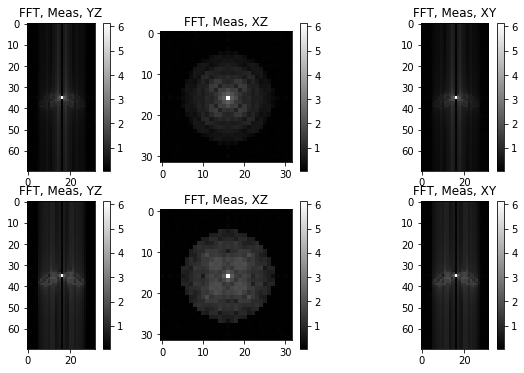

Assuming first axis is time


In [19]:
#%% Display the results
is_display=True
myfwd, mymeas, my_res = sess.run([tf_fwd, tf_meas, muscat.TF_obj], feed_dict={tf_meas:np_meas})
        
if(is_display): plt.subplot(231),plt.title('FFT, Meas, YZ'), plt.imshow(np.abs(np.fft.fftshift(np.fft.fftn(mymeas))**.2)[:,muscat.mysize[1]//2,:]), plt.colorbar()#, plt.show()    
if(is_display): plt.subplot(232),plt.title('FFT, Meas, XZ'), plt.imshow(np.abs(np.fft.fftshift(np.fft.fftn(mymeas))**.2)[muscat.mysize[0]//2,:,:]), plt.colorbar()#, plt.show()   
if(is_display): plt.subplot(233),plt.title('FFT, Meas, XY'), plt.imshow(np.abs(np.fft.fftshift(np.fft.fftn(mymeas))**.2)[:,:,muscat.mysize[2]//2]), plt.colorbar()#, plt.show()     
if(is_display): plt.subplot(234),plt.title('FFT, Meas, YZ'), plt.imshow(np.abs(np.fft.fftshift(np.fft.fftn(myfwd))**.2)[:,muscat.mysize[1]//2,:]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(235),plt.title('FFT, Meas, XZ'), plt.imshow(np.abs(np.fft.fftshift(np.fft.fftn(myfwd))**.2)[muscat.mysize[0]//2,:,:]), plt.colorbar()#, plt.show()    
if(is_display): plt.subplot(236),plt.title('FFT, Meas, XY'), plt.imshow(np.abs(np.fft.fftshift(np.fft.fftn(myfwd))**.2)[:,:,muscat.mysize[2]//2]), plt.colorbar(), plt.show()    

#%% save the results
#np.save(savepath+'/rec.npy', my_res)
import src.data as data
data.export_realdatastack_h5('temp.h5', 'temp', np.array(resultlist))


# Display results ABS/Angle - FWD model

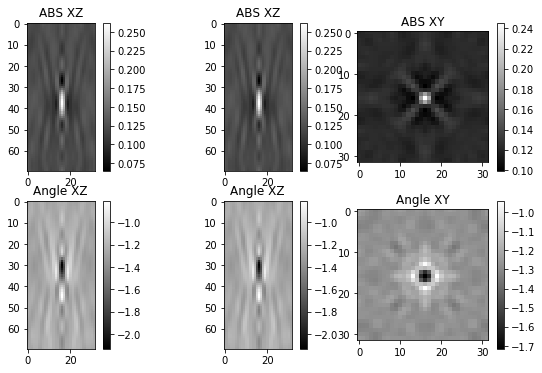

In [20]:

if(is_display): plt.subplot(231), plt.title('ABS XZ'),plt.imshow(np.abs(myfwd)[:,muscat.mysize[1]//2,:]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(232), plt.title('ABS XZ'),plt.imshow(np.abs(myfwd)[:,:,muscat.mysize[2]//2]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(233), plt.title('ABS XY'),plt.imshow(np.abs(myfwd)[muscat.mysize[0]//2,:,:]), plt.colorbar()#, plt.show()

if(is_display): plt.subplot(234), plt.title('Angle XZ'),plt.imshow(np.angle(myfwd)[:,muscat.mysize[1]//2,:]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(235), plt.title('Angle XZ'),plt.imshow(np.angle(myfwd)[:,:,muscat.mysize[2]//2]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(236), plt.title('Angle XY'),plt.imshow(np.angle(myfwd)[muscat.mysize[0]//2,:,:]), plt.colorbar(), plt.show()



# Display Result Refractive index

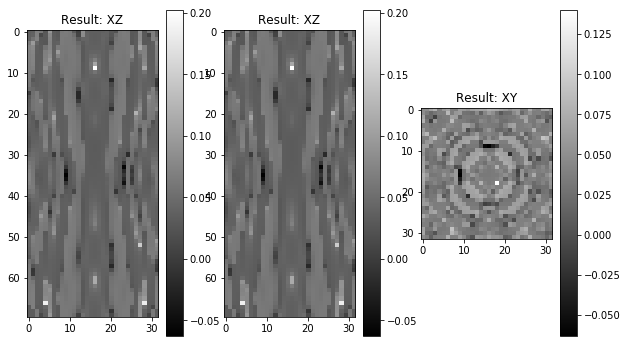

In [21]:
if(False):
    my_residual = tf_helper.abssqr(myfwd-mymeas)
    if(is_display): plt.title('Residual: XZ'),plt.imshow(my_residual [:,muscat.mysize[1]//2,:]), plt.colorbar(), plt.show()
    if(is_display): plt.title('Residual: XZ'),plt.imshow(my_residual [:,:,muscat.mysize[2]//2]), plt.colorbar(), plt.show()
    if(is_display): plt.title('Residual: XY'),plt.imshow(my_residual [muscat.mysize[0]//2,:,:]), plt.colorbar(), plt.show()


if(is_display): plt.subplot(131), plt.title('Result: XZ'),plt.imshow(my_res[:,muscat.mysize[1]//2,:]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(132), plt.title('Result: XZ'),plt.imshow(my_res[:,:,muscat.mysize[2]//2]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(133), plt.title('Result: XY'),plt.imshow(my_res[muscat.mysize[0]//2,:,:]), plt.colorbar(), plt.show()


In [22]:
# Display recovered pupil

[0.  0.  0.  0.  0.  0.  0.1 0.1 0. ]


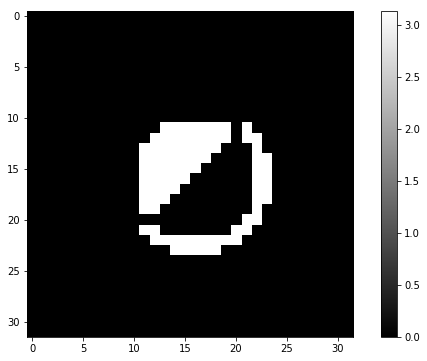

Assuming first axis is time


IndexError: too many indices for array

In [23]:
#plt.subplot(121), plt.imshow(np.angle(sess.run(muscat.TF_Po.eval)))
print(sess.run(muscat.TF_zernikefactors))
plt.imshow(np.angle(np.sum(muscat.myzernikes*sess.run(muscat.TF_zernikefactors),2))), plt.colorbar(), plt.show()

np.save('tmp.npy',np.array(resultlist))
data.export_realdatastack_h5('temp.h5', 'temp', my_res)

# Save results

In [ ]:
#%% save the results
np.save(savepath+'/rec.npy', my_res)
data.export_realdatastack_h5('temp.h5', 'temp', my_res)
data.saveHDF5(my_res, savepath+'/Obj_Reconstruction.h5')
data.saveHDF5(np.abs(np_meas), savepath+'/Amplitude_abs.h5')
data.saveHDF5(np.angle(np_meas), savepath+'/Amplitude_angle.h5')